# Exploratory Data Analysis of CS191W Dataset
Nachat Jatusripitak

In [2]:
# Import required packages for data management and visualization
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.style.use('ggplot')

In [3]:
# Load dataset as CSV and print out the first few rows
df = pd.read_csv("../datasets/base.csv")
print(df.head(10))

   row  col        date     pm25_t  u_wind_10m_t  v_wind_10m_t  dew_temp_2m_t  \
0    0    0  2018-07-05   8.317946      1.432791      0.080936      291.41534   
1    0    0  2018-07-06   8.919353      0.748148      0.110430      291.74884   
2    0    0  2018-07-07   8.957355      0.922457      0.196369      292.11148   
3    0    0  2018-07-08   9.513633      1.040234      0.047216      291.94238   
4    0    0  2018-07-09   9.022613      1.154719      0.083273      290.86307   
5    0    0  2018-07-10  10.063774      0.976790      0.045969      291.47990   
6    0    0  2018-07-11  10.022911      0.404936      0.088748      292.56885   
7    0    0  2018-07-12  11.173699      0.189519      0.284812      292.07114   
8    0    0  2018-07-13  11.481783      0.299176      0.200764      291.94904   
9    0    0  2018-07-14  10.089383      0.395432      0.282515      291.47247   

   temp_2m_t  surf_pressure_t  precip_sum_t  frp_t  elevation_t  \
0  295.22916        85304.766      0.0034

## Question 1: what does the dataset generally "look" like?

### Checking for missing values
There are no missing values in the dataset (by construction) - this was confirmed by calling .isnull().

In [5]:
print(df.isnull().sum())

row                0
col                0
date               0
pm25_t             0
u_wind_10m_t       0
v_wind_10m_t       0
dew_temp_2m_t      0
temp_2m_t          0
surf_pressure_t    0
precip_sum_t       0
frp_t              0
elevation_t        0
delta_pm25_t+1     0
delta_pm25_t       0
dtype: int64


### Computing summary statistics
**Features**

PM2.5 today
- Moderate average level (19.55 $\mu g/m^3$).
- Large range (~260 $\mu g/m^3$).
- Very high maximum (266.04 $\mu g/m^3$) but 75th percentile is low (23.4 $\mu g/m^3$) <br>
indicating that data is highly right-skewed with a heavy tail.

Wind (u-v components)
- Mean u-component: near zero, slightly eastward; v-component: positive, slightly northward.
- Standard deviations (~0.7 and 0.64) suggest gentle variability in wind direction/magnitude.

Dewpoint Temperature and Temperature
- Mostly warm, with temp_2m averaging ~296.86 K (~23.7°C) and peaking above 309 K (~36°C).

Surface Pressure
- Inverse relationship with elevation: Lower surface pressure values correspond to higher elevations.
- Narrow interquartile range (Q1–Q3): suggests most areas cluster around mid-elevation pressures.

Precipitation
- Highly skewed: mean is <0.01, median is 0.001 while max is 0.203.
- Most days have little to no rain but a few rainy days skew the data.

Fire Radiative Power (FRP)
- Extremely skewed: mean  is 1.67, median is 0, while max is ~13000.
- Most days have no fires (fires should be rare) but some days have intense fires.
- Strong right skew. May need transformation or thresholding (e.g., frp > 0).

Elevation
- Ranges from 9 to 1743 meters — terrain spans from lowlands to mountains.
- Might help model air dispersion or trap effects.

**Target**

Change in PM2.5 (target)
- Mean close to zero — makes sense for daily change.
- Std = 8.15, min = -213, max = 219 → shows sharp fluctuations on certain days (could be wind/fire/precip related).

In [6]:
print(df.drop(["row", "col"], axis=1).describe().drop(["count"]))

          pm25_t  u_wind_10m_t  v_wind_10m_t  dew_temp_2m_t   temp_2m_t  \
mean   19.561012      0.090709      0.383356     291.654828  296.854763   
std    18.852786      0.704563      0.640754       4.272014    3.199504   
min     4.267569     -4.000725     -3.179524     270.369700  279.223300   
25%     8.575726     -0.344076     -0.045537     288.772500  294.943730   
50%    11.999695      0.058627      0.367404     293.008060  296.964570   
75%    23.405376      0.536065      0.817670     294.959870  298.890140   
max   266.043150      4.283836      3.881630     299.439970  309.296020   

      surf_pressure_t  precip_sum_t         frp_t  elevation_t  \
mean     93817.913035      0.004529      1.671493   646.885331   
std       3126.242527      0.008464     41.588224   318.528501   
min      83741.850000      0.000000      0.000000     9.000000   
25%      91446.197500      0.000005      0.000000   403.000000   
50%      93848.940000      0.000853      0.000000   638.000000   
75%

### Computing correlation matrix
**Strong Relationships**

elevation and surf_pressure: -0.92

- Very strong negative correlation, as expected — higher elevation leads to lower surface pressure.

temp_2m and dew_temp_2m: 0.52

- Strong positive correlation — makes sense, since higher temperatures often correlate with more moisture in the air.

v_wind_10m and temp_2m: 0.4

- Moderate correlation — might indicate warm winds, possibly from specific directions.

**PM2.5-related Insights**

pm25_today and dew_temp_2m: -0.48

- Moderate negative correlation — higher moisture tends to suppress PM2.5.

pm25_today and precip_sum: -0.26

- Also a moderate negative correlation — precipitation likely helps wash PM2.5 out of the atmosphere.

pm25_today and temp_2m: 0.18

- Weak positive — warmer temps might be associated with stagnant air or fires, but the relationship isn't strong.

pm25_today and pm25_change: -0.2

- Slight negative correlation — possibly because large PM2.5 changes tend to occur when levels are low (and vice versa).

pm25_today and frp: 0.13

- Slight positive — not strong, but may still indicate that fire activity can contribute to elevated PM2.5 levels.

**pm25_change (Target Variable)**

No strong correlations with any predictors — this means PM2.5 change may depend on nonlinear interactions or <br>
localized spatiotemporal patterns that a model (like XGBoost) might capture better than simple correlations.

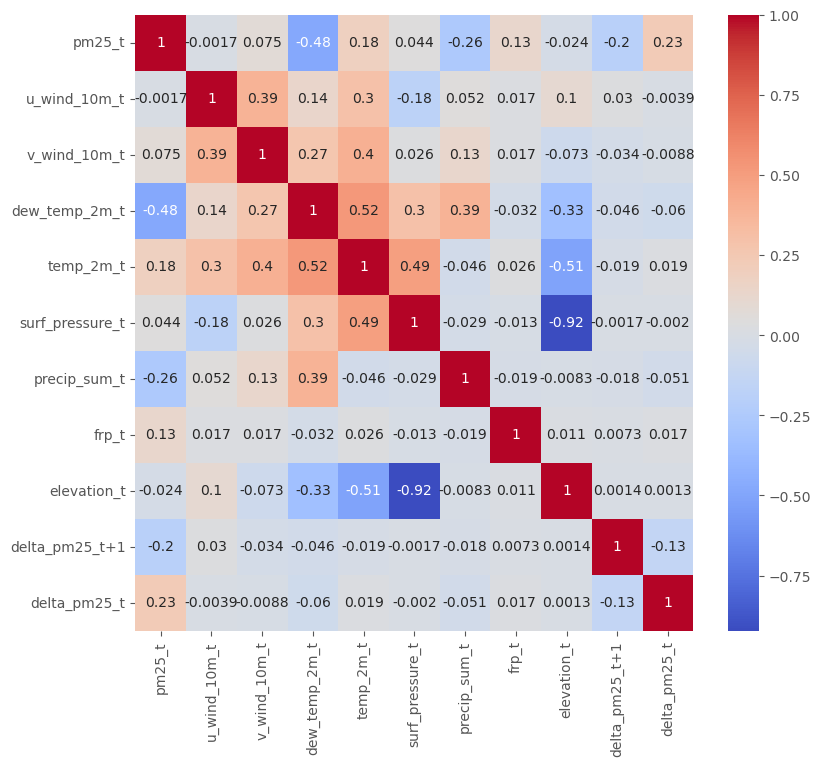

In [9]:
plt.figure(figsize=(9, 8))
sns.heatmap(df.drop(["row", "col", "date"], axis=1).corr(), annot=True, cmap='coolwarm')
plt.show()

## Question 2: How does PM2.5 change vary with current PM2.5 level?
- Scatterplot confirms negative correlation.
- While trend is linear, there is significant spread which indicates unexplained variability
- Conclusion: requires additional covariates to explain the variance.

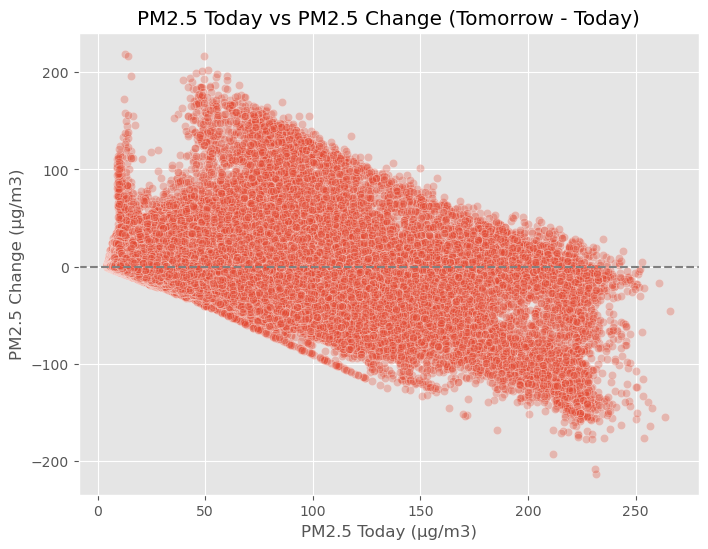

In [11]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='pm25_t', y='delta_pm25_t+1', data=df, alpha=0.3)
plt.title('PM2.5 Today vs PM2.5 Change (Tomorrow - Today)')
plt.xlabel('PM2.5 Today (μg/m3)')
plt.ylabel('PM2.5 Change (μg/m3)')
plt.axhline(0, color='gray', linestyle='--')
plt.show()


## Question 3: How does PM2.5 vary over space?

### Which places have the highest overall PM2.5 concentrations?
- Generally, the Northeastern areas of the images have the highest maximum PM2.5 concentrations.
- The lower parts, corresponding to lower Northern Thailand, have lower maximums.
- Extreme values can be found in the upper-right of the image, up to 250 $\mu g/m^3$.

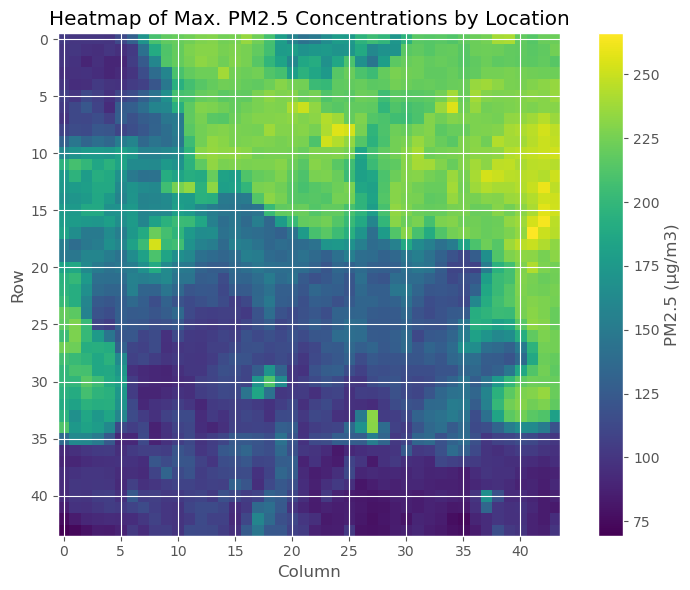

In [12]:
# Group data by grid location and take maximums
max_pm25_locs = (df.groupby(["row", "col"])["pm25_t"]
                 .max()
                 .sort_values(ascending=False))

# Convert data to heatmap
heatmap_df = max_pm25_locs.unstack(level='col')
data = heatmap_df.values  
fig, ax = plt.subplots(figsize=(8,6))

# origin='upper' makes row 0 draw at the top
im = ax.imshow(data, origin='upper', aspect='equal')

ax.set_xlabel('Column')
ax.set_ylabel('Row')
ax.set_title('Heatmap of Max. PM2.5 Concentrations by Location')

fig.colorbar(im, ax=ax, label='PM2.5 (μg/m3)')
plt.tight_layout()
plt.show()

### Which places have the highest mean PM2.5 concentrations?
- Central part of the image has highest mean PM2.5 concentrations.
- This area corresponds to urban places (Chiang Mai, Chiang Rai, etc.) and may <br>
indicate long-term accumulation of PM2.5.

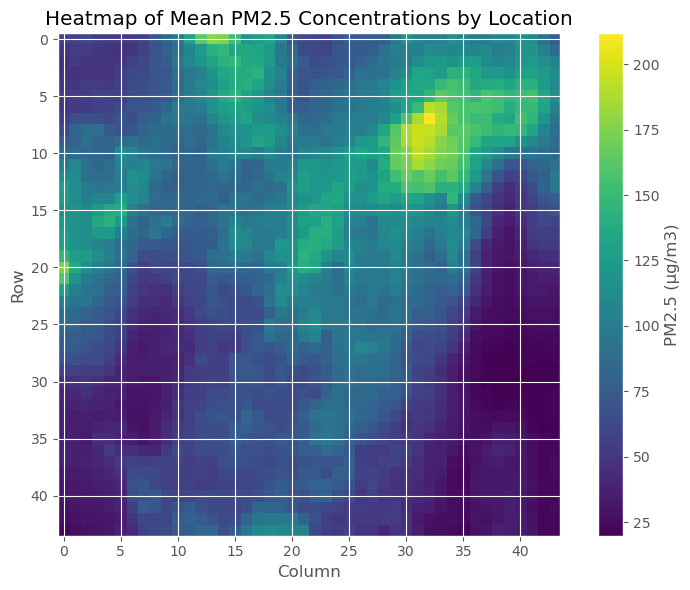

In [22]:
# Group data by grid location and take maximums
loc_pm25 = df.query("date == '2020-03-25'")['pm25_t']

# Convert data to heatmap
data = loc_pm25.values.reshape([44, 44])
fig, ax = plt.subplots(figsize=(8,6))

# origin='upper' makes row 0 draw at the top
im = ax.imshow(data, origin='upper', aspect='equal')

ax.set_xlabel('Column')
ax.set_ylabel('Row')
ax.set_title('Heatmap of Mean PM2.5 Concentrations by Location')

fig.colorbar(im, ax=ax, label='PM2.5 (μg/m3)')
plt.tight_layout()
plt.show()

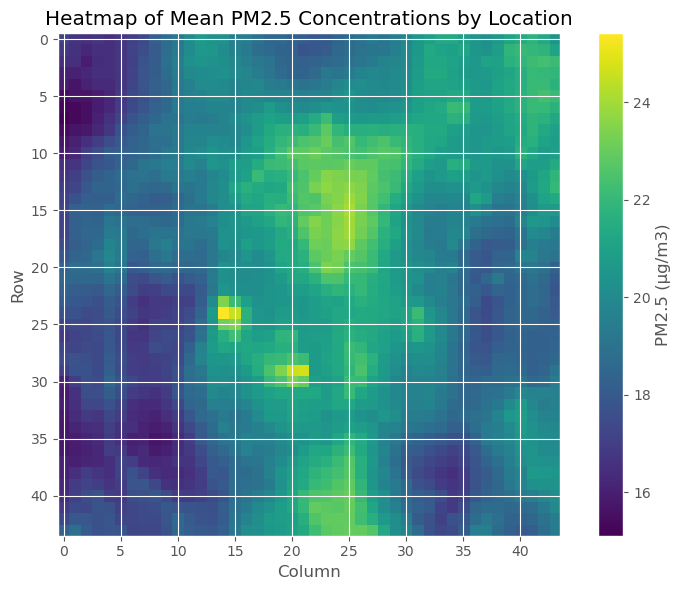

In [13]:
# Group data by grid location and take maximums
mean_pm25_locs = (df.groupby(["row", "col"])["pm25_t"]
                 .mean()
                 .sort_values(ascending=False))

# Convert data to heatmap
heatmap_df = mean_pm25_locs.unstack(level='col')
data = heatmap_df.values  
fig, ax = plt.subplots(figsize=(8,6))

# origin='upper' makes row 0 draw at the top
im = ax.imshow(data, origin='upper', aspect='equal')

ax.set_xlabel('Column')
ax.set_ylabel('Row')
ax.set_title('Heatmap of Mean PM2.5 Concentrations by Location')

fig.colorbar(im, ax=ax, label='PM2.5 (μg/m3)')
plt.tight_layout()
plt.show()

## Question 4: How does PM2.5 vary over time?

### How does PM2.5 vary seasonally?
- Low PM2.5 levels during June-September
- Levels start to increase during October-February
- Peak levels in March
- Levels decline during April-May

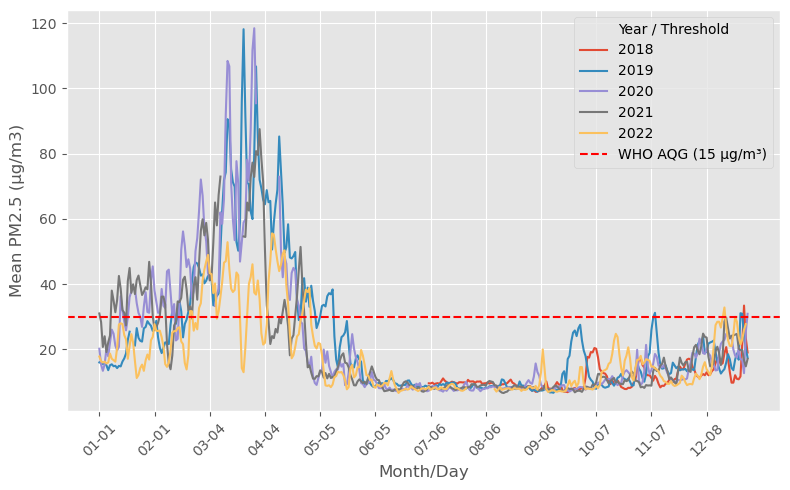

In [6]:
# Copy dataset to avoid changing original
df_copy = df.copy()

# Create year and month-day labels
df_copy['date'] = pd.to_datetime(df_copy['date'], format='%Y-%m-%d')
df_copy['year'] = df_copy['date'].dt.year
df_copy['month'] = df_copy['date'].dt.month
df_copy['md']   = df_copy['date'].dt.strftime('%m-%d')

# Pivot so each column is a year, indexed by 'MM-DD'
pivot = df_copy.pivot_table(
    index='md',
    columns='year',
    values='pm25_t',
    aggfunc='mean'
)

# Force calendar order for all month-days (using a dummy non-leap year)
md_range = pd.date_range('2021-01-01','2021-12-31').strftime('%m-%d')
pivot = pivot.reindex(md_range, fill_value=np.nan)

# Plot overlapping time series
plt.figure(figsize=(8,5))
for yr in pivot.columns:
    plt.plot(pivot.index, pivot[yr], label=str(yr))

# add a dashed red line at y = 30
plt.axhline(30, color='red', linestyle='--', linewidth=1.5, label='WHO AQG (15 µg/m³)')

plt.xticks(pivot.index[::31], rotation=45)
plt.xlabel('Month/Day')
plt.ylabel('Mean PM2.5 (μg/m3)')
plt.legend(title='Year / Threshold')
plt.tight_layout()
plt.show()


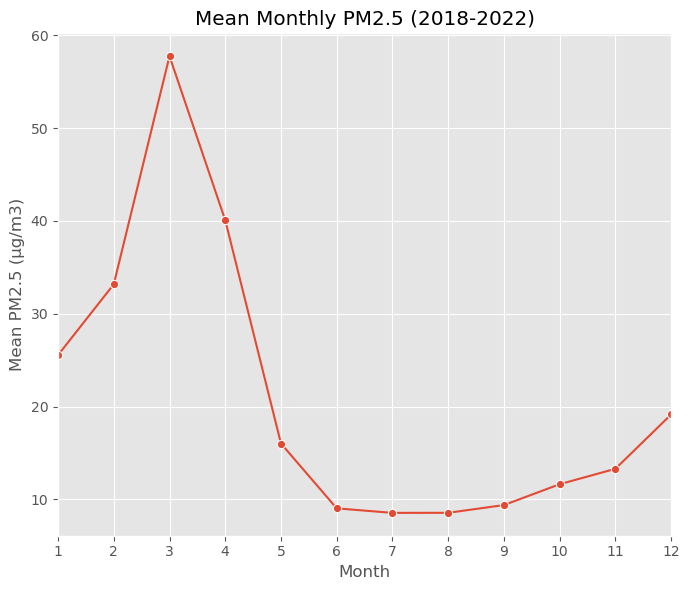

In [ ]:
monthly_avg_pm25 = df_copy.groupby("month")["pm25_t"].mean()

df_month = monthly_avg_pm25.reset_index()
df_month.columns = ['month', 'value']

plt.figure(figsize=(7,6))
sns.lineplot(
    data=df_month,
    x='month',
    y='value',
    marker='o'
)
plt.xticks(range(1,13))     
plt.xlim(1,12)
plt.xlabel('Month')
plt.ylabel('Mean PM2.5 (μg/m3)')
plt.title('Mean Monthly PM2.5 (2018-2022)')
plt.tight_layout()
plt.show()


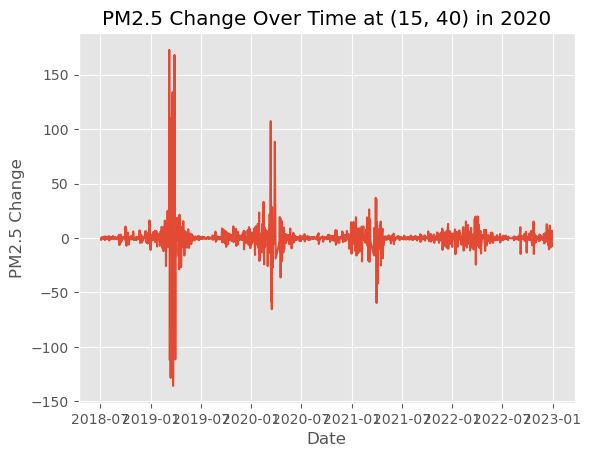

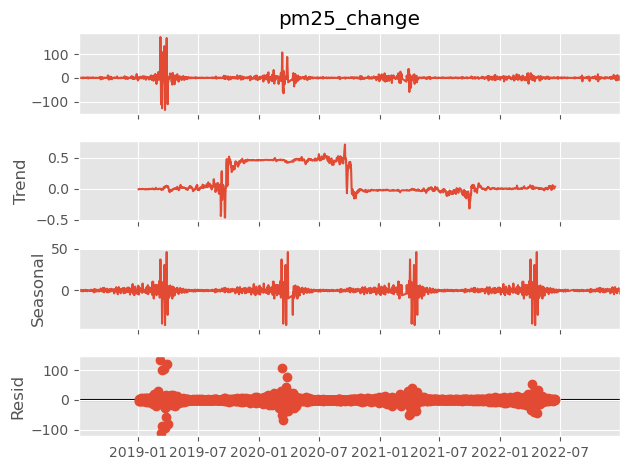

In [ ]:
df_copy["date"] = pd.to_datetime(df_copy["date"])  # Ensure datetime

df_filtered = df_copy[
    (df_copy["row"] == 15) & 
    (df_copy["col"] == 40)
].sort_values('date')

pm25_ts = df_filtered[["date", "pm25_change"]].set_index("date")

plt.plot(pm25_ts.index, pm25_ts["pm25_change"])
plt.xlabel("Date")
plt.ylabel("PM2.5 Change")
plt.title("PM2.5 Change Over Time at (15, 40) in 2018-2022")
plt.grid(True)
plt.show()


# ETS Decomposition using the datetime-indexed series
result = seasonal_decompose(pm25_ts["pm25_change"], model='additive', period=365)

# ETS plot
result.plot()
plt.show()


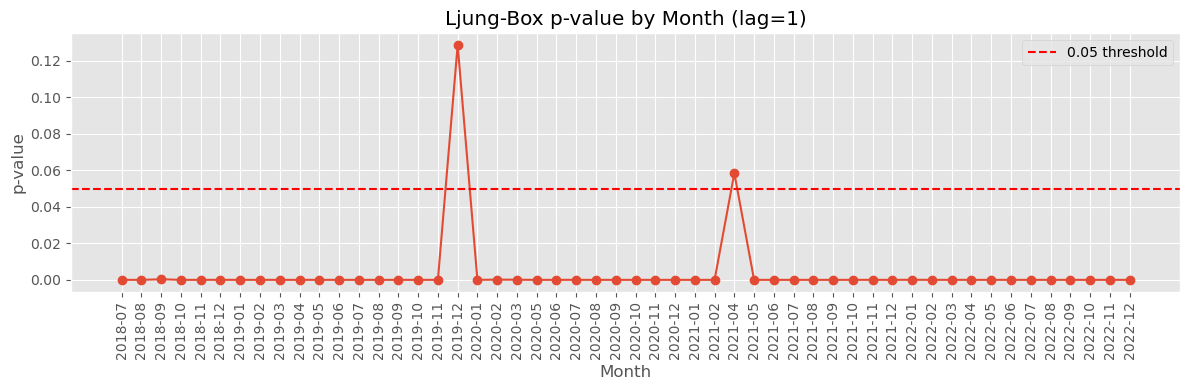

In [37]:
df_copy = df.copy()

df_copy["date"] = pd.to_datetime(df_copy["date"])  # Ensure datetime

df_copy["year_month"] = df_copy["date"].dt.to_period("M")

df_copy = df_copy[
    (df_copy["row"] == 4) & 
    (df_copy["col"] == 20)
]


results = []
for period, group in df_copy.groupby("year_month"):
    ts = group["pm25_change"].dropna()
    
    ts = ts.sort_values()
    
    if len(ts) >= 20:  # require enough data points to test lags
        lb_test = acorr_ljungbox(ts, lags=[20], return_df=True)
        p_value = lb_test["lb_pvalue"].iloc[-1]
        results.append({"month": str(period), "p_value": p_value})

results_df = pd.DataFrame(results)

plt.figure(figsize=(12, 4))
plt.plot(results_df["month"], results_df["p_value"], marker='o')
plt.axhline(0.05, color='red', linestyle='--', label='0.05 threshold')
plt.xticks(rotation=90)
plt.title("Ljung-Box p-value by Month (lag=1)")
plt.ylabel("p-value")
plt.xlabel("Month")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

